# Imports

In [3]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import gc, joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## import data

In [7]:
def import_data(seq_length):
    matrix_array = np.load(f'Data/matrix_array_{seq_length}_normalized.npy')
    answer_array = np.load(f'Data/answer_array_{seq_length}.npy')

    X = matrix_array
    y = answer_array

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=1, stratify=y)

    X_test_flattened = np.array([x.flatten() for x in X_test])

    y_test_transformed = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else -1) for y in y_test])
    # answer = chunk.iloc[i+19][['plus_6', 'minus_6', 'zero_6']].tolist()
    # zero = 0, up = 1, down = -1
    y_test_transformed012 = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else 2) for y in y_test])
    # 1 = up , 2 = down, 0 = zero

    del X, y, X_train, X_test, y_train, y_test, matrix_array, answer_array
    gc.collect()

    return X_test_flattened, y_test_transformed, y_test_transformed012


## test models

In [8]:
def test_model(model_name, seq_length):
    X_test_flattened, y_test_transformed, y_test_transformed012 = import_data(seq_length)
    print(f'import {seq_length} Data Done')

    if model_name == 'XGB':
        y_test_transformed = y_test_transformed012
        
    model = joblib.load(f'Models/{model_name}_model_{seq_length}.pkl')
    print(f'import {model_name} model Done')

    y_pred = model.predict(X_test_flattened)
    print('prediction Done')

    print(np.unique(y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test_transformed, y_pred)
    print(f"Accuracy: {accuracy}")

    # Print classification report
    report = classification_report(y_test_transformed, y_pred)
    print("Classification Report:")
    print(report)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_transformed, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'{model_name}_{seq_length} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'Figures/{model_name}_{seq_length}_Counfusion_Matrix.png')
    plt.show()

    # accuracy?
    wrong_count = cm[0][1]+cm[0][2] + cm[1][0]+cm[1][2] + cm[2][0]+cm[2][1]
    correct_count = cm[0][0] + cm[1][1] + cm[2][2]

    print(f'wrong count : {wrong_count}, correct count : {correct_count}')
    print(f'accuracy? : {100*correct_count/(wrong_count+correct_count)}') 

    data = pd.read_csv('Data/df_all.csv')
    data = data.drop(['Open time', 'Close time', 'Ignore','up_cross','down_cross','minutes','log_minutes','side','plus_6','minus_6','zero_6'], axis=1)
    print(data.columns)

    # Rename columns
    new_columns = []
    for i in range(seq_length):  # for each time step
        new_columns.extend([f"{col}_{i}" for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume','MA5','MA10','MA20','MA30','MA60','MA120','MA240', 'BB0','BB+','BB-' ]])

    # Get feature importances
    importances = model.feature_importances_
    # Convert to a DataFrame
    feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    feature_importance_df.plot(kind='bar', x='Feature', y='Importance')
    plt.title('Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Display the top N features in a bar chart
    top_n = 20  # You can adjust this number
    top_features = feature_importance_df.head(top_n)
    top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
    plt.title('Top Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Print the sorted list of features and their importances
    print("Sorted Feature Importances:")
    print(feature_importance_df.to_string(index=False))

    # Assuming importances and new_columns are defined
    feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

    # Split the feature names and aggregate importances
    feature_importance_df['BaseFeature'] = feature_importance_df['Feature'].apply(lambda x: x.split('_')[0])
    aggregated_importances = feature_importance_df.groupby('BaseFeature')['Importance'].sum()

    # Sort by importance
    aggregated_importances = aggregated_importances.sort_values(ascending=False)

    # Plot aggregated feature importances
    aggregated_importances.head(20).plot(kind='bar', figsize=(10, 6))
    plt.title('Aggregated Feature Importances')
    plt.ylabel('Importance')
    plt.show()

    # Print the sorted list of aggregated features and their importances
    print("Sorted Aggregated Feature Importances:")
    print(aggregated_importances.to_string())


## predictions

import 20 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5738314539037618
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69     21477
           1       0.55      0.43      0.48     17617
           2       0.54      0.45      0.49     18991

    accuracy                           0.57     58085
   macro avg       0.56      0.56      0.55     58085
weighted avg       0.57      0.57      0.56     58085



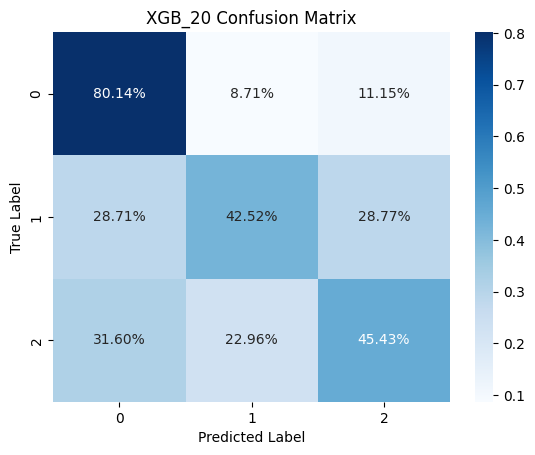

wrong count : 24754, correct count : 33331
accuracy? : 57.38314539037617
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


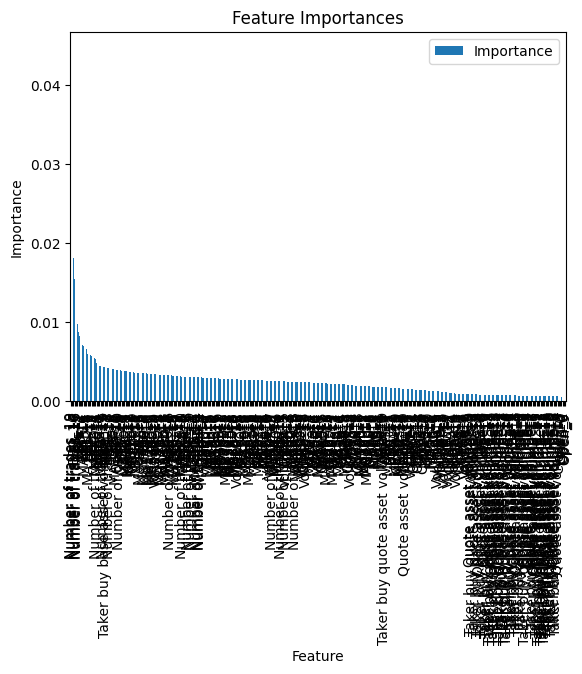

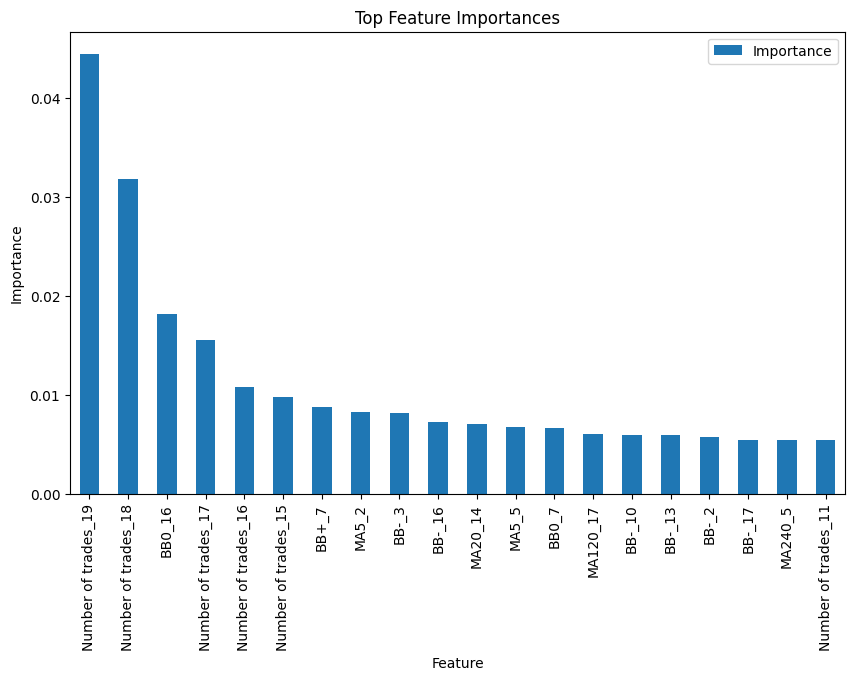

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_19    0.044499
            Number of trades_18    0.031806
                         BB0_16    0.018132
            Number of trades_17    0.015507
            Number of trades_16    0.010821
            Number of trades_15    0.009741
                          BB+_7    0.008790
                          MA5_2    0.008240
                          BB-_3    0.008137
                         BB-_16    0.007190
                        MA20_14    0.007011
                          MA5_5    0.006777
                          BB0_7    0.006592
                       MA120_17    0.006024
                         BB-_10    0.005928
                         BB-_13    0.005920
                          BB-_2    0.005762
                         BB-_17    0.005445
                        MA240_5    0.005439
            Number of trades_11    0.005404
                         BB+_13    0.004853
    

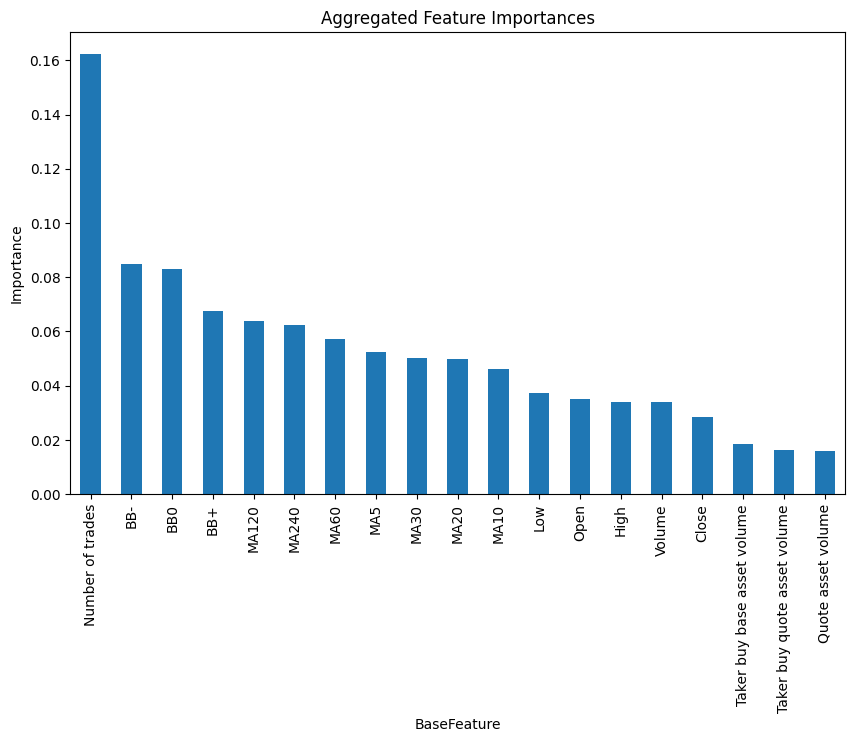

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.162233
BB-                             0.084728
BB0                             0.083183
BB+                             0.067561
MA120                           0.063917
MA240                           0.062497
MA60                            0.057371
MA5                             0.052417
MA30                            0.050134
MA20                            0.049825
MA10                            0.046349
Low                             0.037381
Open                            0.035082
High                            0.033940
Volume                          0.033839
Close                           0.028531
Taker buy base asset volume     0.018628
Taker buy quote asset volume    0.016449
Quote asset volume              0.015935
import 40 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5801457038044883
Classification Report:
              precision    recall  f1-score   suppor

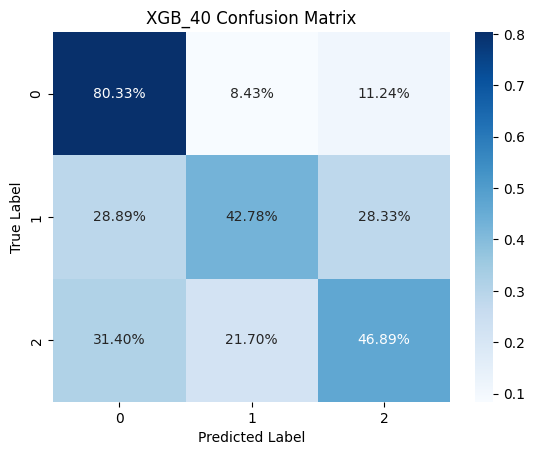

wrong count : 24378, correct count : 33685
accuracy? : 58.01457038044882
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


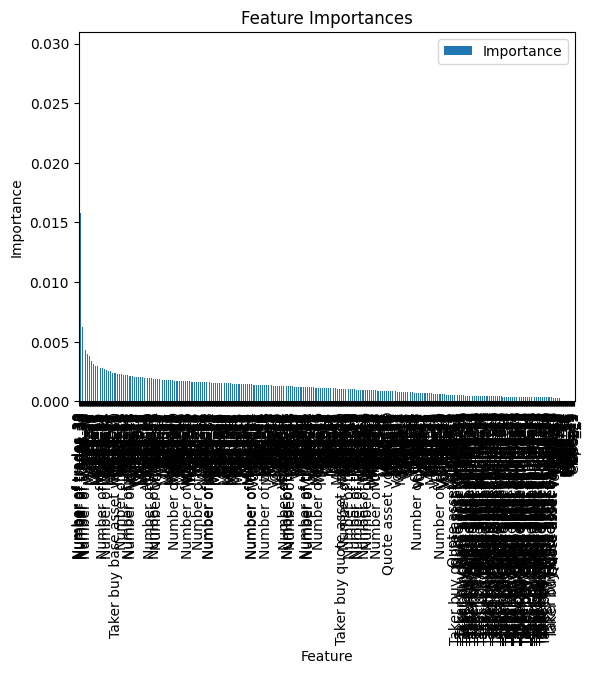

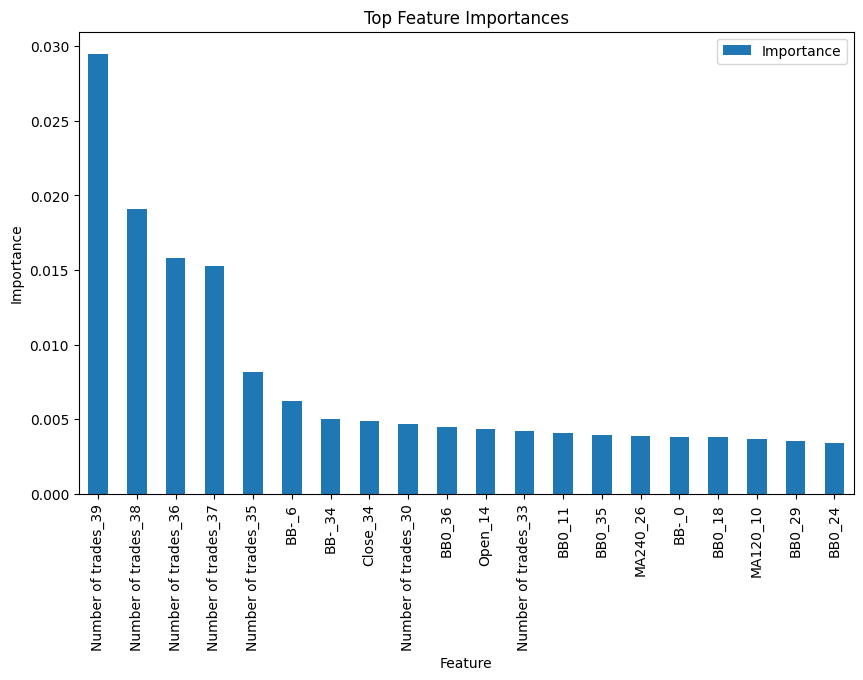

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_39    0.029500
            Number of trades_38    0.019072
            Number of trades_36    0.015803
            Number of trades_37    0.015285
            Number of trades_35    0.008192
                          BB-_6    0.006208
                         BB-_34    0.004999
                       Close_34    0.004890
            Number of trades_30    0.004646
                         BB0_36    0.004480
                        Open_14    0.004325
            Number of trades_33    0.004218
                         BB0_11    0.004076
                         BB0_35    0.003952
                       MA240_26    0.003867
                          BB-_0    0.003797
                         BB0_18    0.003778
                       MA120_10    0.003666
                         BB0_29    0.003555
                         BB0_24    0.003407
                        MA240_5    0.003351
    

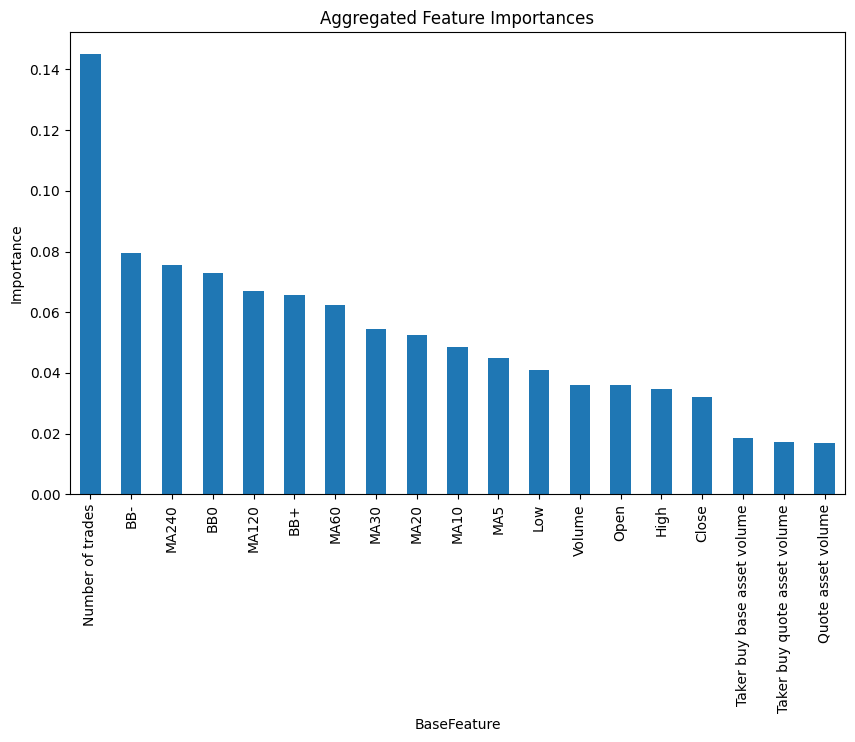

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.145022
BB-                             0.079402
MA240                           0.075459
BB0                             0.072934
MA120                           0.067072
BB+                             0.065687
MA60                            0.062418
MA30                            0.054307
MA20                            0.052435
MA10                            0.048439
MA5                             0.044823
Low                             0.040811
Volume                          0.036008
Open                            0.035844
High                            0.034698
Close                           0.032018
Taker buy base asset volume     0.018458
Taker buy quote asset volume    0.017120
Quote asset volume              0.017047
import 60 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5833634844334178
Classification Report:
              precision    recall  f1-score   suppor

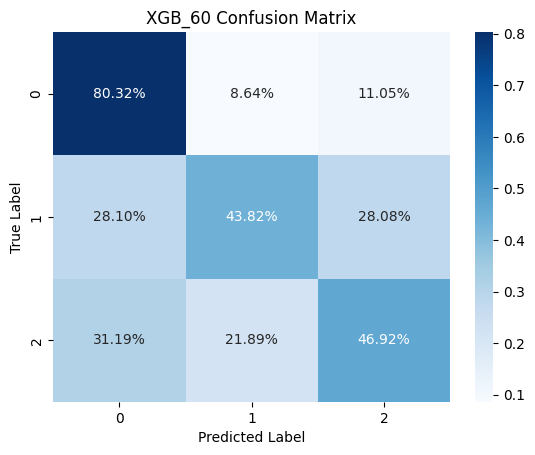

wrong count : 24182, correct count : 33859
accuracy? : 58.33634844334178
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


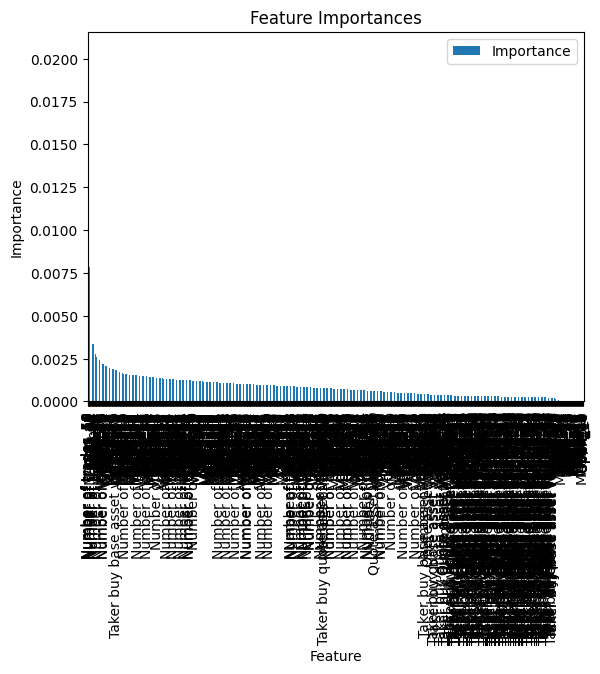

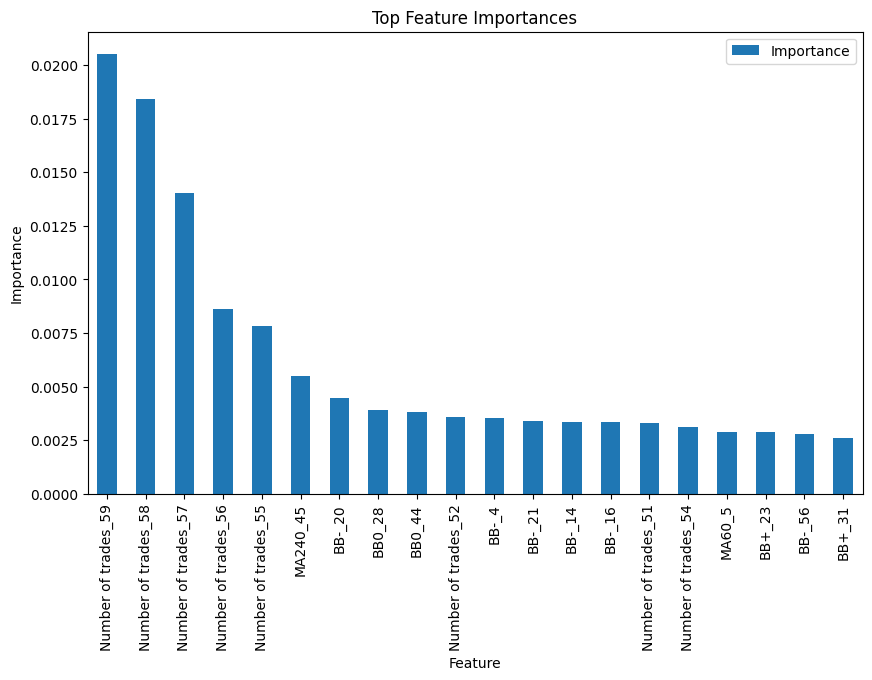

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_59    0.020536
            Number of trades_58    0.018429
            Number of trades_57    0.014058
            Number of trades_56    0.008634
            Number of trades_55    0.007849
                       MA240_45    0.005511
                         BB-_20    0.004473
                         BB0_28    0.003899
                         BB0_44    0.003807
            Number of trades_52    0.003585
                          BB-_4    0.003556
                         BB-_21    0.003375
                         BB-_14    0.003349
                         BB-_16    0.003342
            Number of trades_51    0.003288
            Number of trades_54    0.003128
                         MA60_5    0.002872
                         BB+_23    0.002860
                         BB-_56    0.002774
                         BB+_31    0.002603
                        MA60_52    0.002601
    

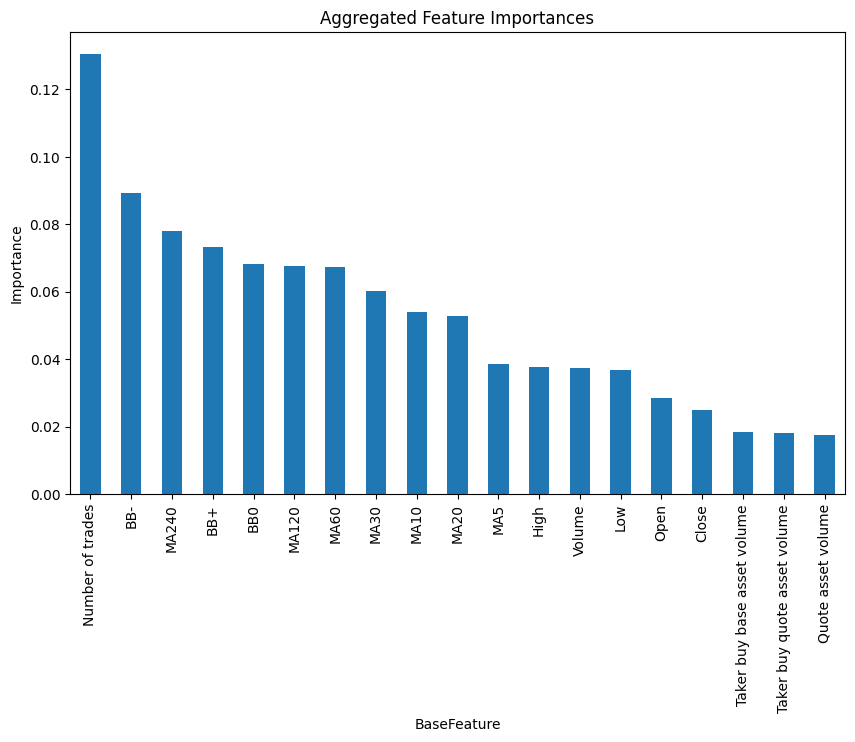

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.130438
BB-                             0.089375
MA240                           0.078062
BB+                             0.073263
BB0                             0.068206
MA120                           0.067737
MA60                            0.067469
MA30                            0.060387
MA10                            0.054019
MA20                            0.052892
MA5                             0.038480
High                            0.037721
Volume                          0.037458
Low                             0.036696
Open                            0.028383
Close                           0.025025
Taker buy base asset volume     0.018561
Taker buy quote asset volume    0.018175
Quote asset volume              0.017653
import 80 Data Done
import XGB model Done
prediction Done
[0 1 2]
Accuracy: 0.5837742808390355
Classification Report:
              precision    recall  f1-score   suppor

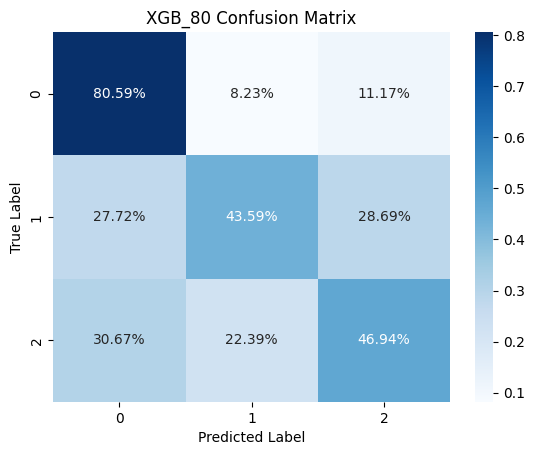

wrong count : 24149, correct count : 33870
accuracy? : 58.377428083903546
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')


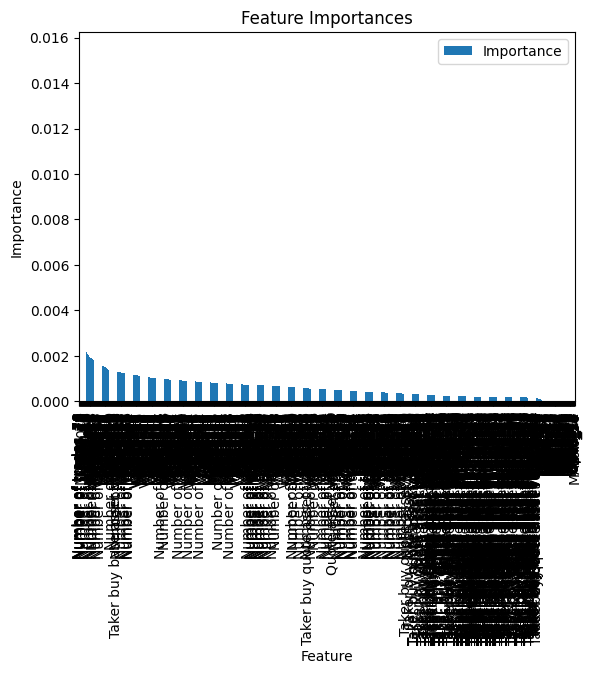

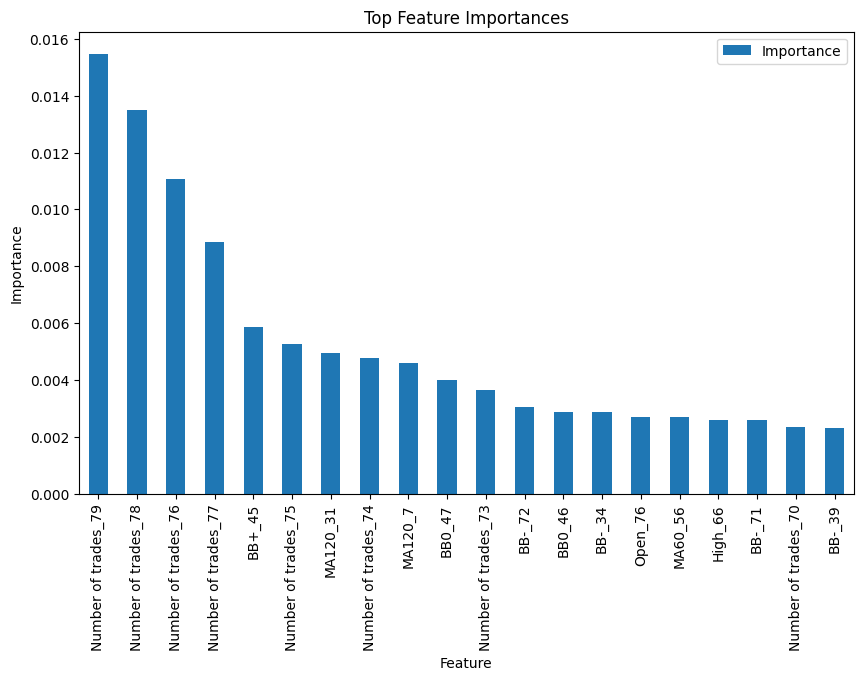

Sorted Feature Importances:
                        Feature  Importance
            Number of trades_79    0.015474
            Number of trades_78    0.013508
            Number of trades_76    0.011074
            Number of trades_77    0.008860
                         BB+_45    0.005868
            Number of trades_75    0.005248
                       MA120_31    0.004938
            Number of trades_74    0.004774
                        MA120_7    0.004610
                         BB0_47    0.003993
            Number of trades_73    0.003650
                         BB-_72    0.003053
                         BB0_46    0.002873
                         BB-_34    0.002867
                        Open_76    0.002693
                        MA60_56    0.002682
                        High_66    0.002596
                         BB-_71    0.002580
            Number of trades_70    0.002335
                         BB-_39    0.002307
                        MA60_35    0.002284
    

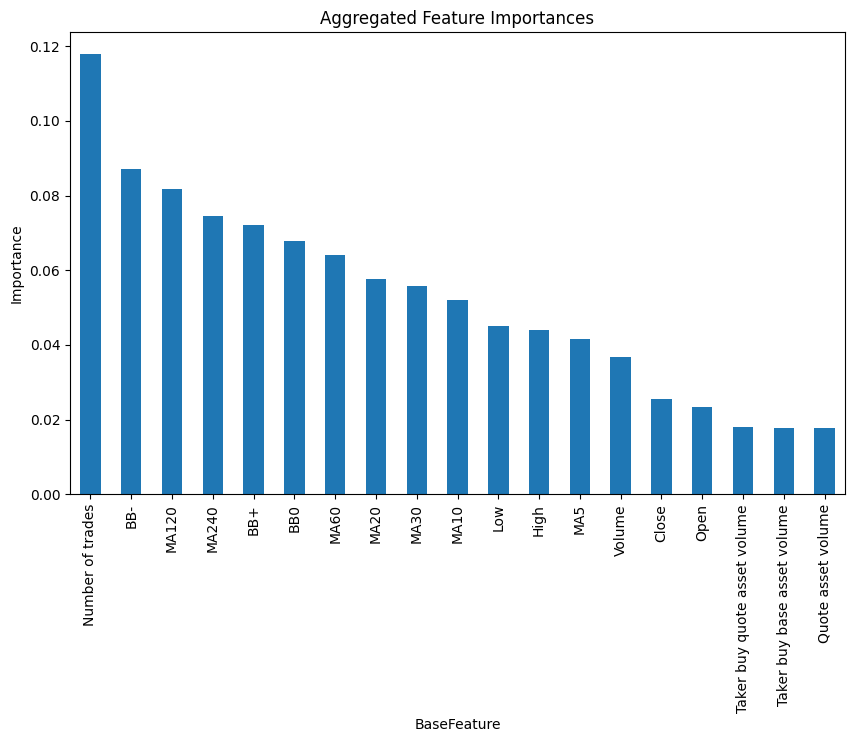

Sorted Aggregated Feature Importances:
BaseFeature
Number of trades                0.117837
BB-                             0.087122
MA120                           0.081630
MA240                           0.074586
BB+                             0.072121
BB0                             0.067836
MA60                            0.063996
MA20                            0.057558
MA30                            0.055896
MA10                            0.051948
Low                             0.045173
High                            0.044010
MA5                             0.041473
Volume                          0.036618
Close                           0.025450
Open                            0.023443
Taker buy quote asset volume    0.017985
Taker buy base asset volume     0.017707
Quote asset volume              0.017611


In [10]:
seq_lengths = [20,40,60,80]
models = [
    'RFC', 
    'XGB',
    ]

for seq_length in seq_lengths:
    for model_name in models:
        test_model(model_name, seq_length)